## Facetted subgrids - Implementation

This notebook is about implementation of the algorithm sketched out in [facet-subgrid.ipynb](facet-subgrid.ipynb).

### Note: 
- based on facet-subgrid-impl 
- removed all the setup parts from the notebook
- reinserted all the imports, constants, user-defined functions that are needed for the remaining part of the notebook to run

# Implementation

We have selected a configuration from the parameter search above. Let us have a closer look at the chosen parameters, and promote them to variables - these fully characterise our configuration:

In [4]:
# Needed imports

%matplotlib inline

import matplotlib.patches as patches
from matplotlib import pylab

import numpy
import math
import time
import itertools
import scipy.special
import scipy.signal

from ipywidgets import interact_manual, interact
# from crocodile.synthesis import anti_aliasing_function, coordinates, fft, ifft, pad_mid, extract_mid
# from util.visualize import show_image

# Fixing seed of numpy random
numpy.random.seed(123456789)

# Plot setup

pylab.rcParams['figure.figsize'] = 16, 4
pylab.rcParams['image.cmap'] = 'viridis'

In [5]:
# Needed variables

target_pars = {
    'W': 13.25,
    'fov': 0.75,
    'N': 1024,
    'Nx': 4,
    'yB_size': 256,
    'yN_size': 320,
    'yP_size': 512,
    'xA_size': 188,
    'xM_size': 256,
}

target_err = 1e-5

alpha = 0

# needed for degridding
W_steps = 32
Ws = numpy.arange(2,22,1/W_steps)
res = 1024
normal = numpy.prod(numpy.arange(2*alpha-1,0,-2, dtype=float)) # double factorial
pswfs = { W: anti_aliasing_function(res, alpha, numpy.pi*W/2).real / normal
          for W in Ws }

# Note: cell[-3] (defining `test_degrid_accuracy`) also has some extra 
#       functions and variables copied from earlier parts

In [6]:

def coordinates(N):
    """1D array which spans [-.5,.5[ with 0 at position N/2"""
    N2 = N // 2
    if N % 2 == 0:
        return numpy.mgrid[-N2:N2] / N
    else:
        return numpy.mgrid[-N2 : N2 + 1] / N


def fft(a):
    """Fourier transformation from image to grid space

    :param a: image in `lm` coordinate space
    :returns: `uv` grid
    """
    if len(a.shape) == 1:
        return numpy.fft.fftshift(numpy.fft.fft(numpy.fft.ifftshift(a)))
    elif len(a.shape) == 2:
        return numpy.fft.fftshift(numpy.fft.fft2(numpy.fft.ifftshift(a)))
    assert False, "Unsupported image shape for FFT!"


def ifft(a):
    """Fourier transformation from grid to image space

    :param a: `uv` grid to transform
    :returns: an image in `lm` coordinate space
    """
    if len(a.shape) == 1:
        return numpy.fft.fftshift(numpy.fft.ifft(numpy.fft.ifftshift(a)))
    elif len(a.shape) == 2:
        return numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.ifftshift(a)))
    assert False, "Unsupported grid shape for iFFT!"


def pad_mid(ff, N):
    """
    Pad a far field image with zeroes to make it the given size.

    Effectively as if we were multiplying with a box function of the
    original field's size, which is equivalent to a convolution with a
    sinc pattern in the uv-grid.

    :param ff: The input far field. Should be smaller than NxN.
    :param N:  The desired far field size

    """

    N0 = ff.shape[0]
    if N == N0:
        return ff
    assert N > N0
    pad = [(N // 2 - N0 // 2, (N + 1) // 2 - (N0 + 1) // 2)]
    if len(ff.shape) == 2:
        assert N0 == ff.shape[1]
        pad = 2 * pad  # both dimensions
    return numpy.pad(ff, pad, mode="constant", constant_values=0.0)


def extract_mid(a, N):
    """
    Extract a section from middle of a map

    Suitable for zero frequencies at N/2. This is the reverse
    operation to pad.

    :param a: grid from which to extract
    :param s: size of section
    """

    assert N <= a.shape[0]
    cx = a.shape[0] // 2
    s = N // 2
    if len(a.shape) == 2:
        assert N <= a.shape[1]
        cy = a.shape[1] // 2
        if N % 2 != 0:
            return a[cx - s : cx + s + 1, cy - s : cy + s + 1]
        else:
            return a[cx - s : cx + s, cy - s : cy + s]
    elif len(a.shape) == 1:
        if N % 2 != 0:
            return a[cx - s : cx + s + 1]
        else:
            return a[cx - s : cx + s]
    else:
        assert False, "Unsupported grid shape for extract_mid!"


def anti_aliasing_function(shape, m, c):
    """
    Compute the prolate spheroidal anti-aliasing function

    See VLA Scientific Memoranda 129, 131, 132
    :param shape: (height, width) pair or just width
    :param m: mode parameter
    :param c: spheroidal parameter
    """

    # One dimensional?
    if len(numpy.array(shape).shape) == 0:

        pswf = scipy.special.pro_ang1(m, m, c, 2 * coordinates(shape))[0]
        pswf[0] = 0  # zap NaN
        return pswf

    # 2D Prolate spheroidal angular function is seperable
    return numpy.outer(
        anti_aliasing_function(shape[0], m, c), anti_aliasing_function(shape[1], m, c)
    )



# Needed user-defined functions

def fmt(x):
    if x >= 1024*1024 and (x % (1024*1024)) == 0:
        return "%dM" % (x // 1024 // 1024)
    if x >= 1024 and (x % 1024) == 0:
        return "%dk" % (x // 1024)
    return "%d" % x


# Helper for marking ranges in a graph
def mark_range(lbl, x0, x1=None, y0=None, y1=None, ax=None, x_offset=1/200, linestyle='--'):
    if ax is None: ax = pylab.gca()
    if y0 is None: y0 = ax.get_ylim()[1]
    if y1 is None: y1 = ax.get_ylim()[0]
    wdt = ax.get_xlim()[1] - ax.get_xlim()[0]
    ax.add_patch(patches.PathPatch(patches.Path([(x0,y0), (x0,y1)]), linestyle=linestyle))
    if x1 is not None:
        ax.add_patch(patches.PathPatch(patches.Path([(x1,y0), (x1,y1)]), linestyle=linestyle))
    else:
        x1 = x0
    if pylab.gca().get_yscale() == 'linear':
        lbl_y = (y0*7+y1) / 8
    else: # Some type of log scale
        lbl_y = (y0**7*y1)**(1/8)
    ax.annotate(lbl, (x1+x_offset*wdt, lbl_y))
    
    
# Needed for degridding

def find_x_sorted_smooth(xs, ys, y):
    assert(len(xs) == len(ys))
    pos = numpy.searchsorted(ys, y)
    if pos <= 0:
        return xs[0]
    if pos >= len(ys) or ys[pos] == ys[pos-1]:
        return xs[len(ys)-1]
    w = (y - ys[pos-1]) / (ys[pos] - ys[pos-1])
    return xs[pos-1] * (1-w) + xs[pos] * w


def find_x_sorted_logsmooth(xs, ys, y):
    return find_x_sorted_smooth(xs, numpy.log(numpy.maximum(1e-100, ys)), numpy.log(y))

In [7]:
print("== Chosen configuration")
for n in ['W', 'fov', 'N', 'Nx', 'yB_size', 'yN_size', 'yP_size', 'xA_size', 'xM_size']:
    exec(f'{n} = target_pars[n]')
    print(f'{n} = {target_pars[n]}')

print("\n== Relative coordinates")
xN = W / yN_size / 2
xM = xM_size / 2 / N
yN = yN_size / 2
xA = xA_size / 2 / N
yB = yB_size / 2
print("xN=%g xM=%g yN=%g xNyN=%g xA=%g" % (xN, xM, yN, xN*yN, xA))

print("\n== Derived values")
xN_size = N*W/yN_size
xM_yP_size = xM_size * yP_size // N
xMxN_yP_size = xM_yP_size + int(2 * numpy.ceil(xN_size * yP_size / N / 2))
assert((xM_size * yN_size) % N == 0)
xM_yN_size = xM_size * yN_size // N

cfg_name = "%s_%s_%s_%g" % (fmt(N), fmt(yP_size), fmt(xM_size), target_err)
print(f"xN_size={xN_size:.1f} xM_yP_size={xM_yP_size}, xMxN_yP_size={xMxN_yP_size}, xM_yN_size={xM_yN_size}")
if fov is not None:
    nfacet = int(numpy.ceil(N * fov / yB_size))
    print(f"{nfacet}x{nfacet} facets for FoV of {fov} ({N * fov / nfacet / yB_size * 100}% efficiency)")

== Chosen configuration
W = 13.25
fov = 0.75
N = 1024
Nx = 4
yB_size = 256
yN_size = 320
yP_size = 512
xA_size = 188
xM_size = 256

== Relative coordinates
xN=0.0207031 xM=0.125 yN=160 xNyN=3.3125 xA=0.0917969

== Derived values
xN_size=42.4 xM_yP_size=128, xMxN_yP_size=150, xM_yN_size=80
3x3 facets for FoV of 0.75 (100.0% efficiency)


## Calculate PSWF

Calculate PSWF at the full required resolution (facet size)

In [8]:
pswf = anti_aliasing_function(yN_size, alpha, numpy.pi*W/2).real
pswf /= numpy.prod(numpy.arange(2*alpha-1,0,-2, dtype=float)) # double factorial

Check that PSWF indeed satisfies intended bounds:

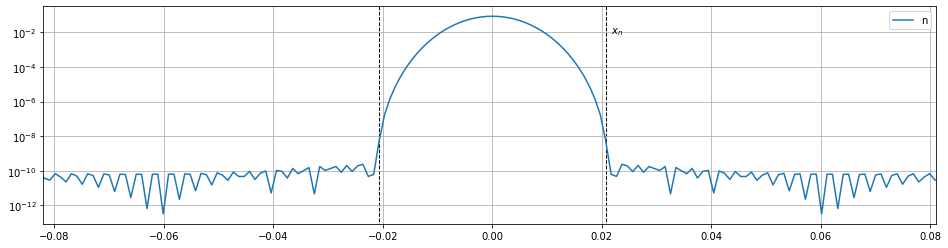

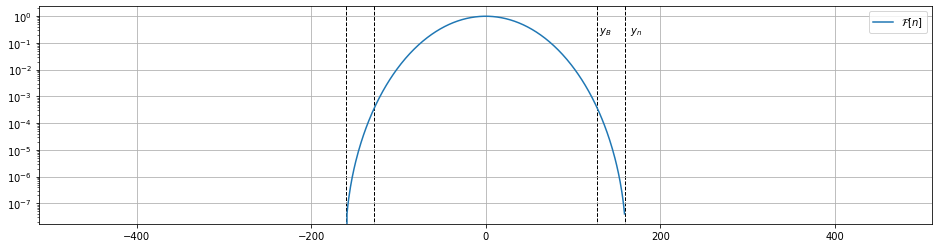

In [9]:
x = coordinates(N); fx = N*coordinates(N)
n = ifft(pad_mid(pswf, N))
pylab.semilogy(coordinates(4*int(xN_size))*4*xN_size/N,
               extract_mid(numpy.abs(ifft(pad_mid(pswf, N))),4*int(xN_size)));
pylab.legend(["n"]);
mark_range("$x_n$", -xN,xN); pylab.xlim(-2*int(xN_size)/N, (2*int(xN_size)-1)/N); pylab.grid(); pylab.show();
pylab.semilogy(coordinates(yN_size)*yN_size, pswf); pylab.legend(["$\\mathcal{F}[n]$"]);
mark_range("$y_B$", -yB,yB); pylab.xlim(-N//2,N//2-1); mark_range("$y_n$", -yN,yN); pylab.grid(); pylab.show();

Calculate actual work terms to use. We need both $n$ and $b$ in image space.

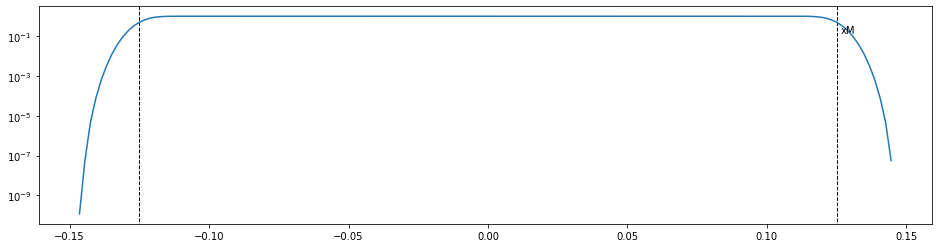

In [10]:
Fb = 1/extract_mid(pswf, yB_size)
Fn = pswf[(yN_size//2)%int(1/2/xM)::int(1/2/xM)]
facet_m0_trunc = pswf * numpy.sinc(coordinates(yN_size)*xM_size/N*yN_size)
facet_m0_trunc = xM_size*yP_size/N * extract_mid(ifft(pad_mid(facet_m0_trunc, yP_size)), xMxN_yP_size).real
pylab.semilogy(coordinates(xMxN_yP_size)/yP_size*xMxN_yP_size, facet_m0_trunc); mark_range("xM", -xM, xM)

## Layout subgrids + facets

In [11]:
nsubgrid = int(math.ceil(N / xA_size))
nfacet = int(math.ceil(N / yB_size))
print("%d subgrids, %d facets needed to cover" % (nsubgrid, nfacet))
subgrid_off = xA_size * numpy.arange(nsubgrid) + Nx
facet_off = yB_size * numpy.arange(nfacet)
def whole(xs): return numpy.all(numpy.abs(xs - numpy.around(xs)) < 1e-13)
assert whole(numpy.outer(subgrid_off, facet_off) / N)
assert whole(facet_off*xM_size/N)

6 subgrids, 4 facets needed to cover


We need a bunch of array constants derived from the gridding function:
 * $\mathcal Fb$ ($y_B$ size)
 * $\mathcal Fn$ ($y_N$ size, sampled at $x_M$ rate), as well as 
 * $\mathcal Fm' = \mathcal Fn\mathcal Fm$ term ($y_P$ size, sampled at $x_M+x_N$).
 
For the convolution with $b$, $n$, and cheap multiplication with $m$ at $y_P$ image size respectively.

Determine subgrid/facet offsets and the appropriate A/B masks for cutting them out. We are aiming for full coverage here: Every pixel is part of exactly one subgrid / facet.

In [12]:
subgrid_A = numpy.zeros((nsubgrid, xA_size), dtype=int)
subgrid_border = (subgrid_off + numpy.hstack([subgrid_off[1:],[N+subgrid_off[0]]])) // 2
for i in range(nsubgrid):
    left = (subgrid_border[i-1] - subgrid_off[i] + xA_size//2) % N
    right = subgrid_border[i] - subgrid_off[i] + xA_size//2
    assert left >= 0 and right <= xA_size, "xA not large enough to cover subgrids!"
    subgrid_A[i,left:right] = 1

facet_B = numpy.zeros((nfacet, yB_size), dtype=bool)
facet_split = numpy.array_split(range(N), nfacet)
facet_border = (facet_off + numpy.hstack([facet_off[1:],[N]])) // 2
for j in range(nfacet):
    left = (facet_border[j-1] - facet_off[j] + yB_size//2) % N
    right = facet_border[j] - facet_off[j] + yB_size//2
    assert left >= 0 and right <= yB_size, "yB not large enough to cover facets!"
    facet_B[j,left:right] = 1

Now calculate the actual subgrids & facets

In [13]:
def make_subgrid_and_facet(G):
    FG = fft(G)
    subgrid = numpy.empty((nsubgrid, xA_size), dtype=complex)
    for i in range(nsubgrid):
        subgrid[i] = subgrid_A[i] * extract_mid(numpy.roll(G, -subgrid_off[i]), xA_size)
    facet = numpy.empty((nfacet, yB_size), dtype=complex)
    for j in range(nfacet):
        facet[j] = facet_B[j] * extract_mid(numpy.roll(FG, -facet_off[j]), yB_size)
    return subgrid, facet
G = numpy.random.rand(N)-0.5
#G = numpy.zeros(N); G[N//2] = 1
#G = fft(FG)
subgrid, facet = make_subgrid_and_facet(G)

## Facet $\rightarrow$ Subgrid

With a few more slight optimisations we arrive at a compact representation for our algorithm. For reference, what we are computing here is:

$$S_i \approx A_i \sum_j (n_j \ast m_i (b_j \ast F_j))$$

where $S_i = A_i G$ and $F_j = B_j \ast G$ are the subgrids and facets respectively.

In [14]:
dtype = numpy.complex128
xN_yP_size = xMxN_yP_size - xM_yP_size
def facets_to_subgrid_1(facet):
    RNjMiBjFj = numpy.empty((nsubgrid, nfacet, xM_yN_size), dtype=dtype)
    for j in range(nfacet):
        BjFj = ifft(pad_mid(facet[j] * Fb, yP_size))
        for i in range(nsubgrid):
            MiBjFj = facet_m0_trunc * extract_mid(numpy.roll(BjFj, -subgrid_off[i]*yP_size//N), xMxN_yP_size)
            MiBjFj_sum = numpy.array(extract_mid(MiBjFj, xM_yP_size))
            MiBjFj_sum[:xN_yP_size//2] += MiBjFj[-xN_yP_size//2:]
            MiBjFj_sum[-xN_yP_size//2:] += MiBjFj[:xN_yP_size//2:]
            RNjMiBjFj[i,j] = Fn * extract_mid(fft(MiBjFj_sum), xM_yN_size)
    return RNjMiBjFj
def facets_to_subgrid_2(nmbfs, i):
    approx = numpy.zeros(xM_size, dtype=complex)
    for j in range(nfacet):
        approx += numpy.roll(pad_mid(nmbfs[i,j], xM_size), facet_off[j]*xM_size//N)
    return subgrid_A[i] * extract_mid(ifft(approx), xA_size)

print("Facet data:", facet.shape, facet.size)
nmbfs = facets_to_subgrid_1(facet)

# - redistribution of nmbfs here -

print("Redistributed data:", nmbfs.shape, nmbfs.size)
approx_subgrid = numpy.array([ facets_to_subgrid_2(nmbfs, i) for i in range(nsubgrid) ])
print("Reconstructed subgrids:", approx_subgrid.shape, approx_subgrid.size)

Facet data: (4, 256) 1024
Redistributed data: (6, 4, 80) 1920
Reconstructed subgrids: (6, 188) 1128


Let us look at the error terms:

RMSE: 4.256552499305892e-08 (image: 5.836290744743e-07 )


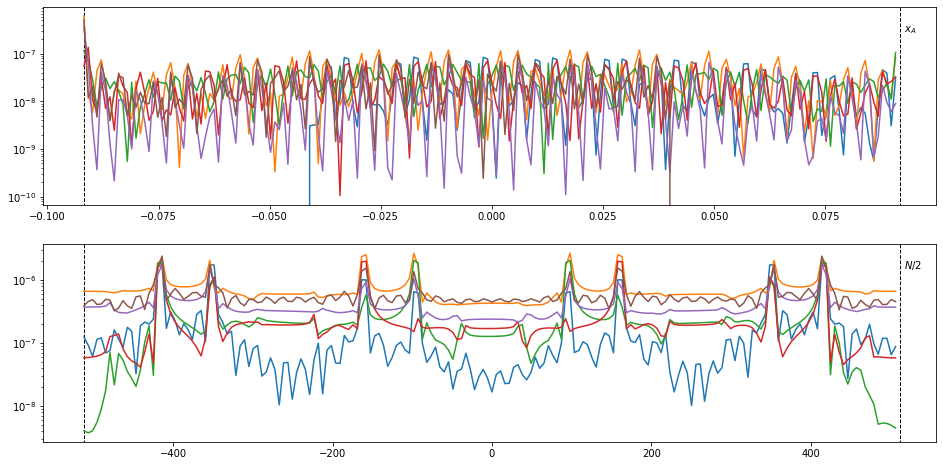

In [15]:
fig = pylab.figure(figsize=(16, 8))
ax1, ax2 = fig.add_subplot(211), fig.add_subplot(212)
err_sum = err_sum_img = 0
for i in range(nsubgrid):
    error = approx_subgrid[i] - subgrid[i]
    ax1.semilogy(xA*2*coordinates(xA_size), numpy.abs(error))
    ax2.semilogy(N*coordinates(xA_size), numpy.abs(fft(error)))
    err_sum += numpy.abs(error)**2 / nsubgrid
    err_sum_img += numpy.abs(fft(error))**2 / nsubgrid
mark_range("$x_A$", -xA, xA, ax=ax1); mark_range("$N/2$", -N/2, N/2, ax=ax2)
print("RMSE:", numpy.sqrt(numpy.mean(err_sum)), "(image:", numpy.sqrt(numpy.mean(err_sum_img)), ")")

By feeding the implementation single-pixel inputs we can create a full error map:

In [16]:
from matplotlib import colors
@interact_manual
def generate_error_map():
    error_map = []
    for xs in range(-N//2, N//2):
        if xs % 128 == 0:
            print(xs, end=' ')
        FG = numpy.zeros(N); FG[xs + N//2] = 1
        subgrid, facet = make_subgrid_and_facet(ifft(FG))
        nmbfs = facets_to_subgrid_1(facet)
        err_map_row = numpy.zeros(N, dtype=complex)
        for i in range(nsubgrid):
            error = facets_to_subgrid_2(nmbfs, i) - subgrid[i]
            err_map_row += numpy.roll(pad_mid(error, N), subgrid_off[i])
        error_map.append(fft(err_map_row))
        
    err_abs = numpy.abs(error_map)
    # Filter out spurious zeroes that would cause division-by-zero
    err_log = numpy.log(numpy.maximum(numpy.min(err_abs[err_abs>0]), err_abs))/numpy.log(10)
    pylab.figure(figsize=(20,20))
    pylab.imshow(err_log, cmap=pylab.get_cmap('inferno'), norm=colors.PowerNorm(gamma=2.0),
                 extent=(-N//2,N//2,-N//2,N//2));
    pylab.colorbar(shrink=0.6); pylab.ylabel('in'); pylab.xlabel('out');
    pylab.title('Output error depending on input pixel (absolute log10)');
    pylab.show()
    
    worst_rmse = 0; worst_err = 0
    for xs in range(N):
        rmse = numpy.sqrt(numpy.mean(numpy.abs(error_map[xs])**2))
        if rmse > worst_rmse: worst_rmse = rmse; worst_err = error_map[xs]
    pylab.semilogy(numpy.abs(worst_err))
    pylab.show()

    worst_rmse = 0; worst_err = 0; em = numpy.array(error_map)
    for xs in range(N):
        rmse = numpy.sqrt(numpy.mean(numpy.abs(em[:,xs])**2))
        if rmse > worst_rmse: worst_rmse = rmse; worst_err = em[:,xs]
    pylab.semilogy(numpy.abs(worst_err))    

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

## Subgrid $\rightarrow$ facet

The other direction works similarly, now we want:
$$F_j \approx b_j \ast \sum_i m_i (n_j \ast S_i)$$

We run into a very similar problem with $m$ as when reconstructing subgrids, except this time it happens because we want to construct:
$$ b_j \left( m_i (n_j \ast S_i)\right)
  = b_j \left( \mathcal F^{-1}\left[\Pi_{2y_P} \mathcal F m_i\right] (n_j \ast S_i)\right)$$

As usual, this is entirely dual: In the previous case we had a signal limited by $y_B$ and needed the result of the convolution up to $y_N$, whereas now we have a signal bounded by $y_N$, but need the convolution result up to $y_B$. This cancels out - therefore we are okay with the same choice of $y_P$.

In [17]:
def subgrid_to_facet_1(subgrid):
    FNjSi = numpy.empty((nsubgrid, nfacet, xM_yN_size), dtype=complex)
    for i in range(nsubgrid):
        FSi = fft(pad_mid(subgrid[i], xM_size))
        for j in range(nfacet):
            FNjSi[i,j] = extract_mid(numpy.roll(FSi, -facet_off[j]*xM_size//N), xM_yN_size)
    return Fn * FNjSi

def subgrid_to_facet_2(nafs, j):
    approx = numpy.zeros(yB_size, dtype=complex)
    for i in range(nsubgrid):
        NjSi = numpy.zeros(xMxN_yP_size, dtype=complex)
        NjSi_mid = extract_mid(NjSi, xM_yP_size)
        NjSi_mid[:] = ifft(pad_mid(nafs[i,j], xM_yP_size)) # updates NjSi via reference!
        NjSi[-xN_yP_size//2:] = NjSi_mid[:xN_yP_size//2]
        NjSi[:xN_yP_size//2:] = NjSi_mid[-xN_yP_size//2:]
        FMiNjSi = fft(numpy.roll(pad_mid(facet_m0_trunc * NjSi, yP_size), subgrid_off[i]*yP_size//N))
        approx += extract_mid(FMiNjSi, yB_size)
    return approx * Fb * facet_B[j]

print("Subgrid data:", subgrid.shape, subgrid.size)
nafs = subgrid_to_facet_1(subgrid)

# - redistribution of FNjSi here -
print("Intermediate data:", nafs.shape, nafs.size)
approx_facet = numpy.array([ subgrid_to_facet_2(nafs, j) for j in range(nfacet) ])
print("Reconstructed facets:", approx_facet.shape, approx_facet.size)

Subgrid data: (6, 188) 1128
Intermediate data: (6, 4, 80) 1920
Reconstructed facets: (4, 256) 1024


RMSE: 1.1820729756131725e-07 (image: 1.8913167609810757e-06 )


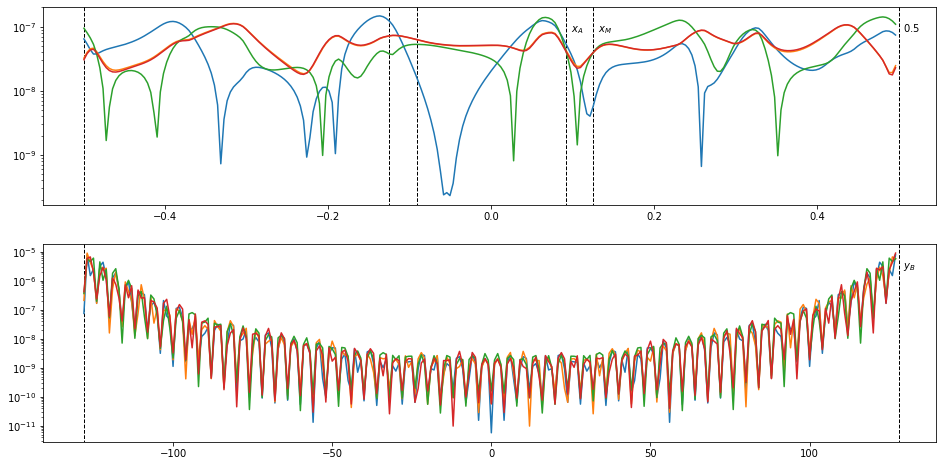

In [18]:
fig = pylab.figure(figsize=(16, 8))
ax1, ax2 = fig.add_subplot(211), fig.add_subplot(212)
err_sum = err_sum_img = 0
for j in range(nfacet):
    error = approx_facet[j] - facet[j]
    err_sum += numpy.abs(ifft(error))**2
    err_sum_img += numpy.abs(error)**2
    ax1.semilogy(coordinates(yB_size), numpy.abs(ifft(error)))
    ax2.semilogy(yB_size*coordinates(yB_size), numpy.abs(error))
print("RMSE:", numpy.sqrt(numpy.mean(err_sum)), "(image:", numpy.sqrt(numpy.mean(err_sum_img)), ")")
mark_range("$x_A$", -xA, xA, ax=ax1); mark_range("$x_M$", -xM, xM, ax=ax1)
mark_range("$y_B$", -yB, yB, ax=ax2); mark_range("$0.5$", -.5, .5, ax=ax1)
pylab.show(fig)

In [19]:
@interact_manual
def generate_error_map_2():
    error_map_2 = []
    for xs in range(-N//2, N//2):
        if xs % 128 == 0:
            print(xs, end=' ')
        FG = numpy.zeros(N); FG[xs + N//2] = 1
        subgrid, facet = make_subgrid_and_facet(ifft(FG))
        nafs = subgrid_to_facet_1(subgrid)

        err_sum_hq = numpy.zeros(N, dtype=complex)

        for j in range(nfacet):
            approx  = subgrid_to_facet_2(nafs, j)
            err_sum_hq += numpy.roll(pad_mid(approx - facet[j], N), facet_off[j])
        error_map_2.append(err_sum_hq)
        
    err_abs = numpy.abs(error_map_2)
    # Filter out spurious zeroes that would cause division-by-zero
    err_log = numpy.log(numpy.maximum(numpy.min(err_abs[err_abs>0]), err_abs))/numpy.log(10)
    pylab.figure(figsize=(20,20))
    pylab.imshow(err_log, cmap=pylab.get_cmap('inferno'), norm=colors.PowerNorm(gamma=2.0),
                 extent=(-N//2,N//2,-N//2,N//2));
    pylab.colorbar(shrink=0.6); pylab.ylabel('in'); pylab.xlabel('out');
    pylab.title('Output error depending on input pixel (absolute log10)');
    tikzplotlib.save('error_map_2.tikz', axis_height='3.5cm', axis_width='\\textwidth', textsize=5, show_info=False);        
    pylab.show()
    
    worst_rmse = 0; worst_err = 0
    for xs in range(N):
        rmse = numpy.sqrt(numpy.mean(numpy.abs(error_map_2[xs])**2))
        if rmse > worst_rmse: worst_rmse = rmse; worst_err = error_map_2[xs]
    pylab.semilogy(numpy.abs(worst_err))    

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

## 2D case

All of this generalises to two dimensions in the way you would expect. Let us set up test data:

In [20]:
print(nsubgrid,"x",nsubgrid,"subgrids,",nfacet,"x", nfacet,"facets")
subgrid_2 = numpy.empty((nsubgrid, nsubgrid, xA_size, xA_size), dtype=complex)
facet_2 = numpy.empty((nfacet, nfacet, yB_size, yB_size), dtype=complex)

G_2 = numpy.exp(2j*numpy.pi*numpy.random.rand(N,N))*numpy.random.rand(N,N)/2
FG_2 = fft(G_2)

FG_2 = numpy.zeros((N,N))
source_count = 1000
sources = [ (numpy.random.randint(-N//2, N//2-1), numpy.random.randint(-N//2, N//2-1),
             numpy.random.rand() * N * N / numpy.sqrt(source_count) / 2) for _ in range(source_count) ]
for x, y, i in sources:
    FG_2[y+N//2,x+N//2] += i
G_2 = ifft(FG_2)
print("Mean grid absolute:", numpy.mean(numpy.abs(G_2)))

for i0,i1 in itertools.product(range(nsubgrid), range(nsubgrid)):
    subgrid_2[i0,i1] = extract_mid(numpy.roll(G_2, (-subgrid_off[i0], -subgrid_off[i1]), (0,1)), xA_size)
    subgrid_2[i0,i1] *= numpy.outer(subgrid_A[i0], subgrid_A[i1])
for j0,j1 in itertools.product(range(nfacet), range(nfacet)):
    facet_2[j0,j1] = extract_mid(numpy.roll(FG_2, (-facet_off[j0], -facet_off[j1]), (0,1)), yB_size)
    facet_2[j0,j1] *= numpy.outer(facet_B[j0], facet_B[j1])

6 x 6 subgrids, 4 x 4 facets
Mean grid absolute: 0.25405295668896377


Given that the amount of data has been squared, performance is a bit more of a concern now. Fortunately, the entire procedure is completely separable, so let us first re-define the operations to work on one array axis exclusively:

In [21]:
def slice_a(fill_val, axis_val, dims, axis):
    return tuple([ axis_val if i == axis else fill_val for i in range(dims) ])
def pad_mid_a(a, N, axis):
    N0 = a.shape[axis]
    if N == N0: return a
    pad = slice_a((0,0), (N//2-N0//2, (N+1)//2-(N0+1)//2), 
                  len(a.shape), axis)    
    return numpy.pad(a, pad, mode='constant', constant_values=0.0)
def extract_mid_a(a, N, axis):
    assert N <= a.shape[axis]
    cx = a.shape[axis] // 2
    if N % 2 != 0:
        slc = slice(cx - N // 2, cx + N // 2 + 1)
    else:
        slc = slice(cx - N // 2, cx + N // 2)
    return a[slice_a(slice(None), slc, len(a.shape), axis)]
def fft_a(a, axis):
    return numpy.fft.fftshift(numpy.fft.fft(numpy.fft.ifftshift(a, axis),axis=axis),axis)
def ifft_a(a, axis):
    return numpy.fft.fftshift(numpy.fft.ifft(numpy.fft.ifftshift(a, axis),axis=axis),axis)
def broadcast_a(a, dims, axis):
    slc = [numpy.newaxis] * dims
    slc[axis] = slice(None)
    return a[slc]
def broadcast_a(a, dims, axis):
    return a[slice_a(numpy.newaxis, slice(None), dims, axis)]

This allows us to define the two fundamental operations - going from $F$ to $b\ast F$ and from $b\ast F$ to $n\ast m(b\ast F)$ separately:

In [22]:
def prepare_facet(facet, axis):
    BF = pad_mid_a(facet * broadcast_a(Fb, len(facet.shape), axis), yP_size, axis)
    BF = ifft_a(BF, axis)
    return BF
def extract_subgrid(BF, i, axis):
    dims = len(BF.shape)
    BF_mid = extract_mid_a(numpy.roll(BF, -subgrid_off[i]*yP_size//N, axis), xMxN_yP_size, axis)
    MBF = broadcast_a(facet_m0_trunc,dims,axis) * BF_mid
    MBF_sum = numpy.array(extract_mid_a(MBF, xM_yP_size, axis))
    xN_yP_size = xMxN_yP_size - xM_yP_size
    # [:xN_yP_size//2] / [-xN_yP_size//2:] for axis, [:] otherwise
    slc1 = slice_a(slice(None), slice(xN_yP_size//2), dims, axis)
    slc2 = slice_a(slice(None), slice(-xN_yP_size//2,None), dims, axis)
    MBF_sum[slc1] += MBF[slc2]
    MBF_sum[slc2] += MBF[slc1]
    return broadcast_a(Fn,len(BF.shape),axis) * \
           extract_mid_a(fft_a(MBF_sum, axis), xM_yN_size, axis)

Having those operations separately means that we can shuffle things around quite a bit without affecting the result. The obvious first choice might be to do all facet-preparation up-front, as this allows us to share the computation across all subgrids:

In [23]:
t = time.time()
NMBF_NMBF = numpy.empty((nsubgrid, nsubgrid, nfacet, nfacet, xM_yN_size, xM_yN_size), dtype=complex)
for j0,j1 in itertools.product(range(nfacet), range(nfacet)):
    BF_F = prepare_facet(facet_2[j0,j1], 0)
    BF_BF = prepare_facet(BF_F, 1)
    for i0 in range(nsubgrid):
        NMBF_BF = extract_subgrid(BF_BF, i0, 0)
        for i1 in range(nsubgrid):
            NMBF_NMBF[i0,i1,j0,j1] = extract_subgrid(NMBF_BF, i1, 1)
print(time.time() - t, "s")

1.2141029834747314 s


However, remember that `prepare_facet` increases the amount of data involved, which in turn means that we need to shuffle more data through subsequent computations.

Therefore it is actually more efficient to first do the subgrid-specific reduction, and *then* continue with the (constant) facet preparation along the other axis. We can tackle both axes in whatever order we like, it doesn't make a difference for the result:

In [24]:
t = time.time()
for j0,j1 in itertools.product(range(nfacet), range(nfacet)):
    BF_F = prepare_facet(facet_2[j0,j1], 0)
    for i0 in range(nsubgrid):
        NMBF_F = extract_subgrid(BF_F, i0, 0)
        NMBF_BF = prepare_facet(NMBF_F, 1)
        for i1 in range(nsubgrid):
            NMBF_NMBF[i0,i1,j0,j1] = extract_subgrid(NMBF_BF, i1, 1)
print(time.time() - t, "s")

0.9912490844726562 s


In [25]:
t = time.time()
for j0,j1 in itertools.product(range(nfacet), range(nfacet)):
    F_BF = prepare_facet(facet_2[j0,j1], 1)
    for i1 in range(nsubgrid):
        F_NMBF = extract_subgrid(F_BF, i1, 1)
        BF_NMBF = prepare_facet(F_NMBF, 0)
        for i0 in range(nsubgrid):
            NMBF_NMBF[i0,i1,j0,j1] = extract_subgrid(BF_NMBF, i0, 0)
print(time.time() - t, "s")

0.7925660610198975 s


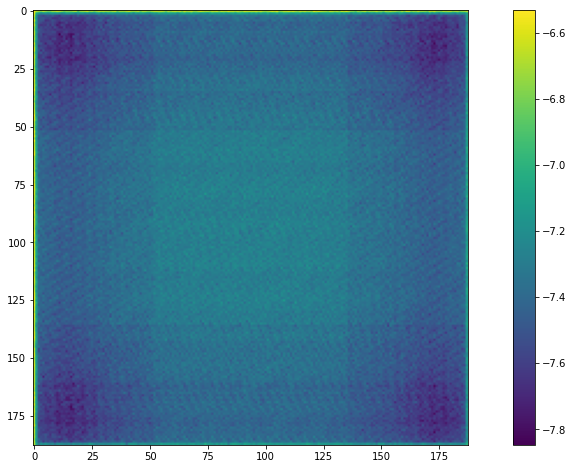

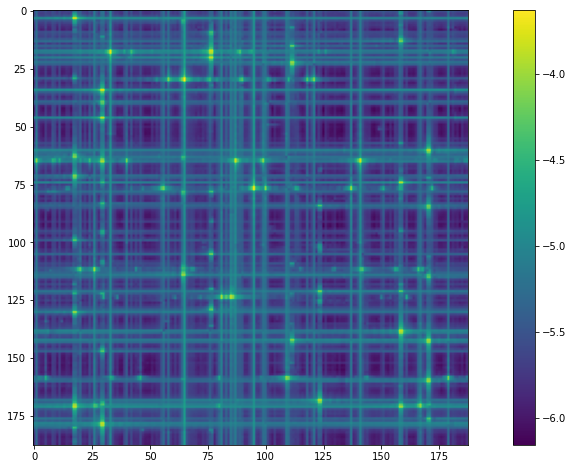

RMSE: 4.757338480166949e-08 (image: 8.943796342713864e-06 )


In [26]:
pylab.rcParams['figure.figsize'] = 16, 8
err_mean = err_mean_img = 0
for i0,i1 in itertools.product(range(nsubgrid), range(nsubgrid)):
    approx = numpy.zeros((xM_size, xM_size), dtype=complex)
    for j0,j1 in itertools.product(range(nfacet), range(nfacet)):
        approx += numpy.roll(pad_mid(NMBF_NMBF[i0,i1,j0,j1], xM_size),
                             (facet_off[j0]*xM_size//N, facet_off[j1]*xM_size//N), (0,1))
    approx = extract_mid(ifft(approx), xA_size)
    approx *= numpy.outer(subgrid_A[i0], subgrid_A[i1])
    err_mean += numpy.abs(approx - subgrid_2[i0,i1])**2 / nsubgrid**2
    err_mean_img += numpy.abs(fft(approx - subgrid_2[i0,i1]))**2 / nsubgrid**2
pylab.imshow(numpy.log(numpy.sqrt(err_mean)) / numpy.log(10)); pylab.colorbar(); pylab.show()
pylab.imshow(numpy.log(numpy.sqrt(err_mean_img)) / numpy.log(10)); pylab.colorbar(); pylab.show()
print("RMSE:", numpy.sqrt(numpy.mean(err_mean)), "(image:", numpy.sqrt(numpy.mean(err_mean_img)), ")")

In [27]:
@interact(xs=(0,N), ys=(0,N))
def test_accuracy(xs=252,ys=252):
    subgrid_2 = numpy.empty((nsubgrid, nsubgrid, xA_size, xA_size), dtype=complex)
    facet_2 = numpy.empty((nfacet, nfacet, yB_size, yB_size), dtype=complex)

    #G_2 = numpy.exp(2j*numpy.pi*numpy.random.rand(N,N))*numpy.random.rand(N,N)/2
    #FG_2 = fft(G_2)

    FG_2 = numpy.zeros((N,N))
    FG_2[ys,xs] = 1
    G_2 = ifft(FG_2)

    for i0,i1 in itertools.product(range(nsubgrid), range(nsubgrid)):
        subgrid_2[i0,i1] = extract_mid(numpy.roll(G_2, (-subgrid_off[i0], -subgrid_off[i1]), (0,1)), xA_size)
        subgrid_2[i0,i1] *= numpy.outer(subgrid_A[i0], subgrid_A[i1])
    for j0,j1 in itertools.product(range(nfacet), range(nfacet)):
        facet_2[j0,j1] = extract_mid(numpy.roll(FG_2, (-facet_off[j0], -facet_off[j1]), (0,1)), yB_size)
        facet_2[j0,j1] *= numpy.outer(facet_B[j0], facet_B[j1])

    NMBF_NMBF = numpy.empty((nsubgrid, nsubgrid, nfacet, nfacet, xM_yN_size, xM_yN_size), dtype=complex)
    for j0,j1 in itertools.product(range(nfacet), range(nfacet)):
        BF_F = prepare_facet(facet_2[j0,j1], 0)
        BF_BF = prepare_facet(BF_F, 1)
        for i0 in range(nsubgrid):
            NMBF_BF = extract_subgrid(BF_BF, i0, 0)
            for i1 in range(nsubgrid):
                NMBF_NMBF[i0,i1,j0,j1] = extract_subgrid(NMBF_BF, i1, 1)

    pylab.rcParams['figure.figsize'] = 16, 8
    err_mean = err_mean_img = 0
    for i0,i1 in itertools.product(range(nsubgrid), range(nsubgrid)):
        approx = numpy.zeros((xM_size, xM_size), dtype=complex)
        for j0,j1 in itertools.product(range(nfacet), range(nfacet)):
            approx += numpy.roll(pad_mid(NMBF_NMBF[i0,i1,j0,j1], xM_size),
                                 (facet_off[j0]*xM_size//N, facet_off[j1]*xM_size//N), (0,1))
        approx = extract_mid(ifft(approx), xA_size)
        approx *= numpy.outer(subgrid_A[i0], subgrid_A[i1])
        err_mean += numpy.abs(approx - subgrid_2[i0,i1])**2 / nsubgrid**2
        err_mean_img += numpy.abs(fft(approx - subgrid_2[i0,i1]))**2 / nsubgrid**2
    #pylab.imshow(numpy.log(numpy.sqrt(err_mean)) / numpy.log(10)); pylab.colorbar(); pylab.show()
    pylab.imshow(numpy.log(numpy.sqrt(err_mean_img)) / numpy.log(10)); pylab.colorbar(); pylab.show()
    print("RMSE:", numpy.sqrt(numpy.mean(err_mean)), "(image:", numpy.sqrt(numpy.mean(err_mean_img)), ")")

interactive(children=(IntSlider(value=252, description='xs', max=1024), IntSlider(value=252, description='ys',…